## Prompting

In [1]:
import json
import random

import matplotlib.pyplot as plt
import numpy as np

In [2]:
def vote_by_majority(responses):
    votes = dict()
    passed = dict()
    
    for response in responses:
        source = response[0]
        source = '\n'.join(
            [
                line for line in source.split('\n') 
                if not line.startswith('```') and not line.strip().startswith('def ')
            ])
        if source not in votes:
            passed[source] = response[1]['result'] == "passed"
            votes[source] = 0
        votes[source] += 1
    
    max_votes = max(votes.values())
    top_sources = [src for src, count in votes.items() if count == max_votes]
    chosen_source = random.choice(top_sources)
    
    return chosen_source, max_votes, passed[chosen_source]

def pass_at_any_for(responses_path):
    with open(responses_path) as f:
        benchmark_responses = json.load(f)
    
    passed_count = 0
    for id in benchmark_responses:
        source, votes, is_passed = vote_by_majority(benchmark_responses[id])
        if is_passed:
            passed_count += 1
    
    return passed_count


In [3]:
def pretty_print_results(benchmark, models):
    model_wise_results = list()
    for model in models:
        results = [
            pass_at_any_for(f'results/{benchmark}_{model}.json'),
            pass_at_any_for(f'results/{benchmark}_{model}_instruction.json'),
            pass_at_any_for(f'results/{benchmark}_{model}_rule.json'),
        ]
        print(model, '\t'.join(map(str, results)), sep='\t')
        model_wise_results.append(results)
    return model_wise_results

In [66]:
def load_and_visualize(benchmark, models, technique_wise_results):
    data1 = technique_wise_results[0]
    data2 = technique_wise_results[1]
    data3 = technique_wise_results[2]

    x = np.arange(len(models))  # label locations
    width = 0.25  # width of the bars

    fig, ax = plt.subplots()
    bars1 = ax.bar(x - width, data1, width, label='Baseline', color='#7fc97f')
    bars2 = ax.bar(x, data2, width, label='Instruction', color='#beaed4')
    bars3 = ax.bar(x + width, data3, width, label='Rule', color='#fdc086')

    ax.set_xlabel('Model')
    ax.set_ylabel(r'$\it{pass@1}$')
    ax.set_title(benchmark + r' $\it{pass@1}$ by Model and Prompt')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.grid(True, axis='y', linestyle='--')
    ax.legend()

    plt.tight_layout()
    plt.savefig(f'results/figures/{benchmark}_prompts.png', dpi=300)

llama3	54	51	19
llama3.1	85	81	47
mistral-nemo	56	56	45
qwen2.5-coder	108	124	120


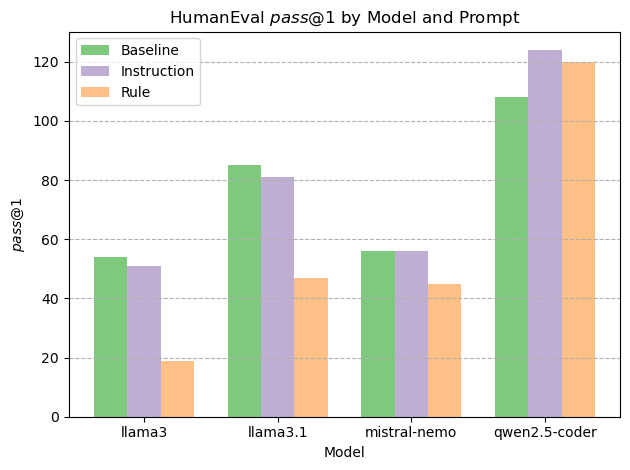

In [77]:
random.seed(42)

benchmark = 'HumanEval'
models = ['llama3', 'llama3.1', 'mistral-nemo', 'qwen2.5-coder']

model_wise_results = pretty_print_results(benchmark, models)
technique_wise_results = [[model_wise_results[j][i] for j in range(4)] for i in range(3)]
load_and_visualize(benchmark, models, technique_wise_results)

llama3	23	19	17
llama3.1	17	11	1
mistral-nemo	30	32	15
qwen2.5-coder	21	14	6


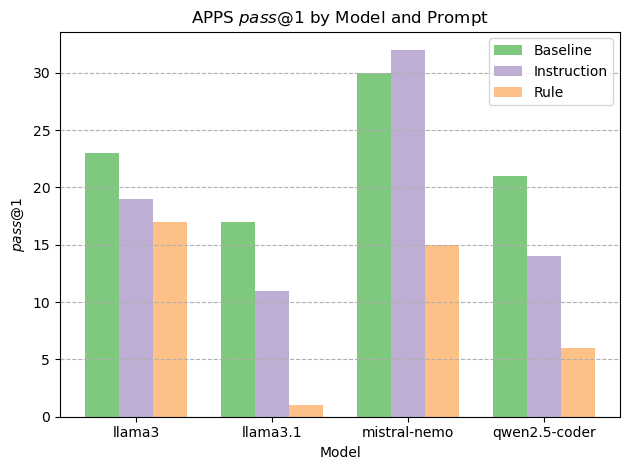

In [78]:
random.seed(42)

benchmark = 'APPS'
models = ['llama3', 'llama3.1', 'mistral-nemo', 'qwen2.5-coder']

model_wise_results = pretty_print_results(benchmark, models)
technique_wise_results = [[model_wise_results[j][i] for j in range(4)] for i in range(3)]
load_and_visualize(benchmark, models, technique_wise_results)

In [69]:
def load_and_visualize_vote_method(benchmark, models, technique_wise_results, vote_method):
    data1 = technique_wise_results[0]
    data2 = technique_wise_results[1]
    data3 = technique_wise_results[2]

    x = np.arange(len(models))  # label locations
    width = 0.25  # width of the bars

    fig, ax = plt.subplots()
    bars1 = ax.bar(x - width, data1, width, label='Baseline', color='#7fc97f')
    bars2 = ax.bar(x, data2, width, label='Instruction', color='#beaed4')
    bars3 = ax.bar(x + width, data3, width, label='Rule', color='#fdc086')

    ax.set_xlabel('Model')
    ax.set_ylabel(r'$\it{pass@1}$')
    ax.set_title(benchmark + r' $\it{pass@1}$ by Model and Prompt')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.grid(True, axis='y', linestyle='--')
    ax.legend()

    plt.tight_layout()
    plt.savefig(f'results/figures/{benchmark}_{vote_method}.png', dpi=300)

In [46]:
### Naryeong - Load the results

def load_results(result_file_path):
    technique_wise_results = [[] * 4 for _ in range(3)]

    prompt = None
    with open(result_file_path, 'r') as f:
        for l in f:
            if 'instruction' in l:
                prompt = 'instruction'
            elif 'rule' in l:
                prompt = 'rule'
            elif 'num' not in l and '=' not in l:
                prompt = 'normal'
            elif 'num_passed' in l:
                num_passed = int(l[12:])
                
                if prompt == 'normal':
                    technique_wise_results[0].append(num_passed)
                elif prompt == 'instruction':
                    technique_wise_results[1].append(num_passed)
                elif prompt == 'rule':
                    technique_wise_results[2].append(num_passed)
    
    return technique_wise_results

### Embedding - Cosine Similarity

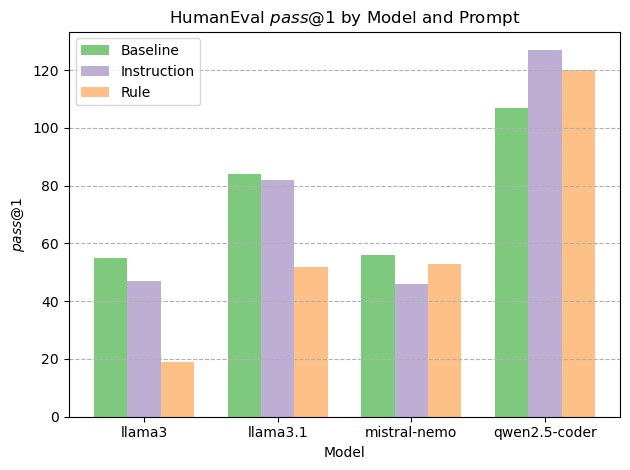

In [70]:
## Human Eval
benchmark = 'HumanEval'
models = ['llama3', 'llama3.1', 'mistral-nemo', 'qwen2.5-coder']
result_file = f'./similarity/codebert_{benchmark.lower()}_results.txt'

technique_wise_results = load_results(result_file)
load_and_visualize_vote_method(benchmark, models, technique_wise_results, 'emb_sim')

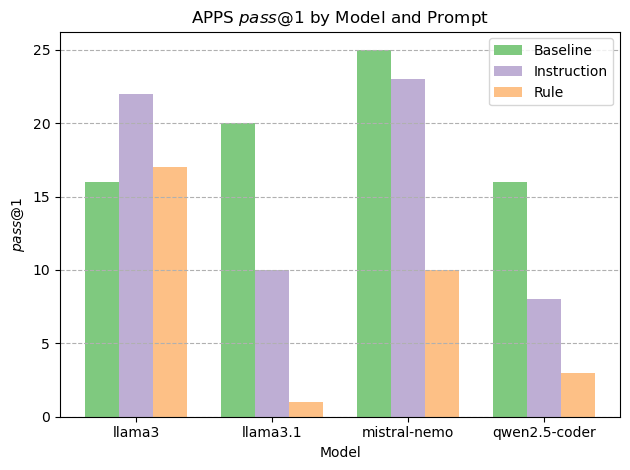

In [71]:
## APPS
benchmark = 'APPS'
models = ['llama3', 'llama3.1', 'mistral-nemo', 'qwen2.5-coder']

result_file = f'./similarity/codebert_{benchmark.lower()}_results.txt'
technique_wise_results = load_results(result_file)
load_and_visualize_vote_method(benchmark, models, technique_wise_results, 'emb_sim')

### AST Edit distance

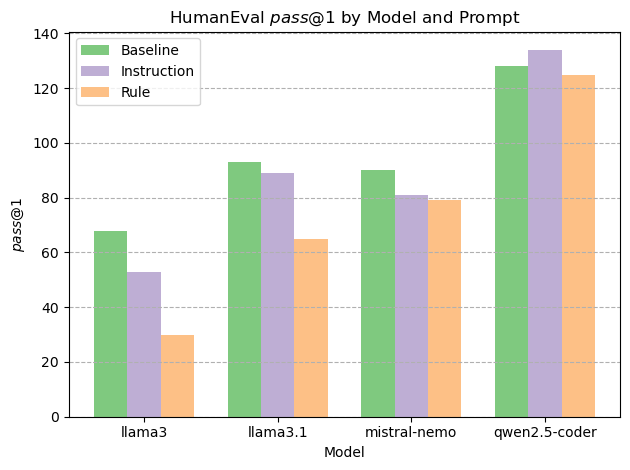

In [72]:
## Human Eval
benchmark = 'HumanEval'
models = ['llama3', 'llama3.1', 'mistral-nemo', 'qwen2.5-coder']
result_file = f'./similarity/ast_edit_dist_{benchmark.lower()}_wo_preprocessing_results.txt'
technique_wise_results = load_results(result_file)
load_and_visualize_vote_method(benchmark, models, technique_wise_results, 'ast_dist')

### Embedding - KMean Clustering

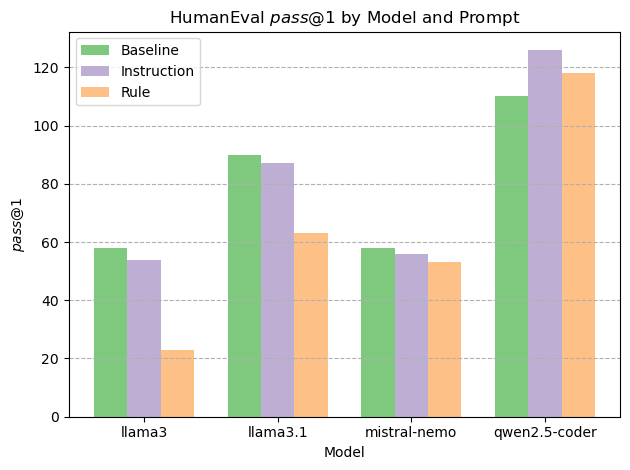

In [73]:
## HumanEval
benchmark = 'HumanEval'
models = ['llama3', 'llama3.1', 'mistral-nemo', 'qwen2.5-coder']

result_file = f'./similarity/codebert_kmean_{benchmark.lower()}_results.txt'
technique_wise_results = load_results(result_file)
load_and_visualize_vote_method(benchmark, models, technique_wise_results, 'clustering')

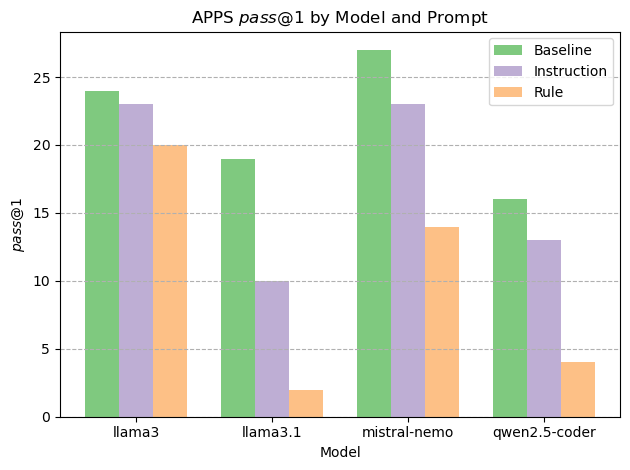

In [74]:
## APPS
benchmark = 'APPS'
models = ['llama3', 'llama3.1', 'mistral-nemo', 'qwen2.5-coder']

result_file = f'./similarity/codebert_kmean_{benchmark.lower()}_results.txt'
technique_wise_results = load_results(result_file)
load_and_visualize_vote_method(benchmark, models, technique_wise_results, 'clustering')

## HumanEval qwen2.5-coder(instruction) Comparison

[[68, 93, 90, 128], [53, 89, 81, 134], [30, 65, 79, 125]]


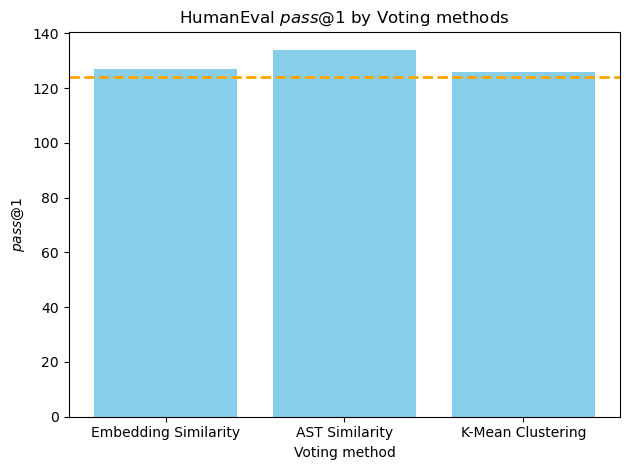

In [82]:


benchmark = 'HumanEval'

## add x element
x_axis = ['Embedding Similarity', 'AST Similarity', 'K-Mean Clustering']

embedding_sim = load_results('./similarity/codebert_humaneval_results.txt')
ast_sim = load_results('./similarity/ast_edit_dist_humaneval_wo_preprocessing_results.txt')
print(ast_sim)
cluster = load_results('./similarity/codebert_kmean_humaneval_results.txt')

# Qwen2.5-coder(instuction)
## add y-value
y_value = []
y_value.append(embedding_sim[1][3])
y_value.append(ast_sim[1][3])
y_value.append(cluster[1][3])

baseline_y_value = 124

x = np.arange(len(x_axis))
width = 0.25

plt.bar(x_axis, y_value, color = 'skyblue')
plt.axhline(y=baseline_y_value, color = 'orange', linestyle='--', linewidth=2, label=f'Baseline ({baseline_y_value})')
plt.title(benchmark + r' $\it{pass@1}$ by Voting methods')
plt.xlabel('Voting method')
plt.ylabel(r'$\it{pass@1}$')
plt.tight_layout()
plt.savefig(f'results/figures/{benchmark}_qwen_inst.png', dpi=300)

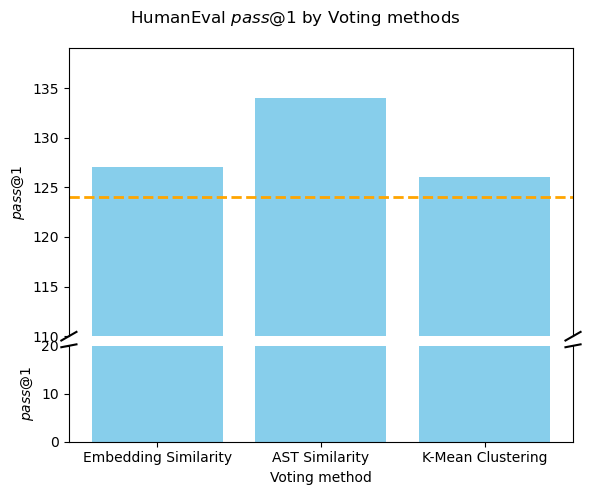

In [89]:
fig, (ax_top, ax_bottom) = plt.subplots(2, 1, sharex=True, figsize=(6, 5), 
                                        gridspec_kw={'height_ratios': [3, 1]})

# 위쪽 축 (생략된 위 구간)
ax_top.bar(x, y_value, color='skyblue')
ax_top.axhline(y=baseline_y_value, color='orange', linestyle='--', linewidth=2, label=f'Baseline ({baseline_y_value})')
ax_top.set_ylim(110, max(y_value) + 5)
ax_top.spines['bottom'].set_visible(False)
ax_top.tick_params(bottom=False)

# 아래쪽 축 (생략된 아래 구간)
ax_bottom.bar(x, y_value, color='skyblue')
ax_bottom.set_ylim(0, 20)
ax_bottom.spines['top'].set_visible(False)

# 물결선 표시
d = 0.015  # 물결 기울기
kwargs = dict(transform=ax_top.transAxes, color='k', clip_on=False)
ax_top.plot([-d, +d], [-d, +d], **kwargs)
ax_top.plot([1 - d, 1 + d], [-d, +d], **kwargs)

kwargs.update(transform=ax_bottom.transAxes)
ax_bottom.plot([-d, +d], [1 - d, 1 + d], **kwargs)
ax_bottom.plot([1 - d, 1 + d], [1 - d, 1 + d], **kwargs)

# 라벨, 제목
fig.suptitle('HumanEval $\it{pass@1}$ by Voting methods')
ax_bottom.set_xlabel('Voting method')
ax_top.set_ylabel(r'$\it{pass@1}$')
ax_bottom.set_ylabel(r'$\it{pass@1}$')
plt.xticks(x, x_axis)

# 저장
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.savefig('results/figures/HumanEval_qwen_inst_wavy_cut_20_90.png', dpi=300)
plt.show()